## MLB Post Season Analysis
By: Brian Preisler
Udacity Data Analysis Nanodegree
November 2016

The questions this analysis will attempt to answer:

- Do the batting averages of American Major League baseball players significantly change either positively or negatively in the post season compared to the regular season?  

- If post season batting averages are significantly different from the regular season, this analysis will look at three potential leading contributors or independent variables to see which, if any, mostly closely affect the dependent variable  
    -Salaries  
    -College experience  
    -Awards earned in regular season

## Load Libraries to be used later

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib as plt 
import seaborn as sns
import scipy
from scipy import stats

## Load data from CSVs

In [42]:
#Imports the datasets as dataframes to be used in the analysis
batting = pd.read_csv('C:\\Users\\brian.preisler\\Python\\P2\\baseballdatabank-master\\core\\batting.csv')
batting_post = pd.read_csv('C:\\Users\\brian.preisler\\Python\\P2\\baseballdatabank-master\\core\\battingpost.csv')
salaries = pd.read_csv('C:\\Users\\brian.preisler\\Python\\P2\\baseballdatabank-master\\core\\salaries.csv')
college_playing = pd.read_csv('C:\\Users\\brian.preisler\\Python\\P2\\baseballdatabank-master\\core\\collegeplaying.csv')
awards = pd.read_csv('C:\\Users\\brian.preisler\\Python\\P2\\baseballdatabank-master\\core\\awardsplayers.csv')


### Look at raw data size,length, etc.

In [43]:
#Print out some data to look at columns as well as original size of datasets
print batting.columns
print 'number of rows in batting:', len(batting)
print 'number of rows in batting in the post season:', len(batting_post)
print 'number of rows in batting after grouping on player:',len(batting.groupby('playerID'))
print 'same for post season:', len(batting_post.groupby('playerID'))

Index([u'playerID', u'yearID', u'stint', u'teamID', u'lgID', u'G', u'AB', u'R',
       u'H', u'2B', u'3B', u'HR', u'RBI', u'SB', u'CS', u'BB', u'SO', u'IBB',
       u'HBP', u'SH', u'SF', u'GIDP'],
      dtype='object')
number of rows in batting: 101332
number of rows in batting in the post season: 11690
number of rows in batting after grouping on player: 18659
same for post season: 3973


## Clean data types

In [44]:
#only use batting stats from the modern era, in alignment with the norm for MLB stat keeping
batting = batting.drop(batting[batting.yearID < 1900].index)
batting_post = batting_post.drop(batting_post[batting_post.yearID < 1900].index)
college_playing = college_playing.drop(college_playing[college_playing.yearID < 1900].index)
salaries = salaries.drop(salaries[salaries.yearID < 1900].index)

#trim down the imported data to just what is needed for simplicity
batting_raw = batting.loc[:, ['playerID', 'H', 'AB']]
batting_post_raw = batting_post.loc[:, ['playerID', 'H', 'AB']]
college_playing_raw = college_playing.loc[:, ['playerID', 'yearID']]
awards_raw = awards.loc[:, ['playerID', 'yearID']]

batting_post_raw.head(10)

,playerID,H,AB
201,colliji01,9,36
202,crigelo01,6,26
203,dinnebi01,2,11
204,doughpa01,8,34
205,farredu01,0,1
206,ferriho01,9,31
207,freembu01,9,31
208,hugheto01,0,0
209,lachaca01,6,25
210,obrieja02,0,2



## Arrange data as needed

In [45]:
#groupbed by player id and then morphed back into df

batting_raw_grouped = batting_raw.groupby('playerID', as_index = False)
batting_post_raw_grouped = batting_post_raw.groupby('playerID',as_index = False)
college_playing_raw_grouped = college_playing_raw.groupby('playerID',as_index = False)
salaries_raw_grouped = salaries.groupby('playerID',as_index = False)
awards_raw_grouped = awards.groupby('playerID',as_index = False)

batting_df = batting_raw_grouped.aggregate(np.sum)
bp_df = batting_post_raw_grouped.aggregate(np.sum)
cp_df = college_playing_raw_grouped.aggregate(np.sum)
salaries_df = salaries_raw_grouped.aggregate(np.sum)
awards_df = awards_raw_grouped.aggregate(np.sum)

In [47]:

#combine the datasets with an inner join to just keep those players that have stats
#in the regular season and post season, and with an outer join to verify if they played
#in college

def combine_dfs(data1, data2):    
    combined = data1.merge(data2, on = 'playerID', how = 'inner')
    return combined

def combine_dfs_left(data1, data2):    
    combined = pd.merge(left = data1, right = data2, how = 'left', left_on = 'playerID', right_on = 'playerID')
    return combined

#combining datasets in order to compare means more easily and verify the same
#number of players
batting_combined = combine_dfs(batting_df, bp_df)

#add an avg column to the dataset for comparison purposes
batting_combined['AVG'] = batting_combined['H_x'] / batting_combined['AB_x']
batting_combined['AVGPOST'] = batting_combined['H_y'] / batting_combined['AB_y']

#create a difference column to see which players performed better or worse in post season
batting_combined['AVG_DIFF'] = batting_combined['AVGPOST'] - batting_combined['AVG']

#using aforementioned function to keep all players in both datasets
batting_combined_college = combine_dfs_left(batting_combined, cp_df)
batting_combined_awards = combine_dfs_left(batting_combined, awards_df)

#print len(batting_combined_college)

#in order to make a binary column later on, replace Nans with a 0
batting_combined_college['yearID'].fillna(0, inplace=True)
batting_combined_awards['yearID'].fillna(0, inplace=True)


print batting_combined_college.head()

    playerID     H_x     AB_x  H_y  AB_y       AVG   AVGPOST  AVG_DIFF  yearID
0  aaronha01  3771.0  12364.0   25    69  0.304998  0.362319  0.057320     0.0
1  aaronto01   216.0    944.0    0     1  0.228814  0.000000 -0.228814     0.0
2   abadfe01     1.0      8.0    0     0  0.125000       NaN       NaN     0.0
3  abbated01   748.0   2942.0    0     1  0.254249  0.000000 -0.254249     0.0
4  abbotje01   157.0    596.0    0     1  0.263423  0.000000 -0.263423  5977.0


## Continue to prep data for future correlation analysis

In [48]:
#define function to be used to add binary column
def invert(data):
    if data > 0:
        return 1
    else:
        return 0   
def played_in_college(df):
    over_write = df['yearID'].apply(invert)
    df['yearID'] = over_write
    return df
          
college_dataset = played_in_college(batting_combined_college)
awards_dataset = played_in_college(batting_combined_awards)

college_dataset.head()

,playerID,H_x,AB_x,H_y,AB_y,AVG,AVGPOST,AVG_DIFF,yearID
0,aaronha01,3771.0,12364.0,25,69,0.304998,0.362319,0.057320,0
1,aaronto01,216.0,944.0,0,1,0.228814,0.000000,-0.228814,0
2,abadfe01,1.0,8.0,0,0,0.125000,NaN,NaN,0
3,abbated01,748.0,2942.0,0,1,0.254249,0.000000,-0.254249,0
4,abbotje01,157.0,596.0,0,1,0.263423,0.000000,-0.263423,1


## Investigating the data

The average of players batting in the regular season is: 0.218
The average of players batting in the post season is: 0.197


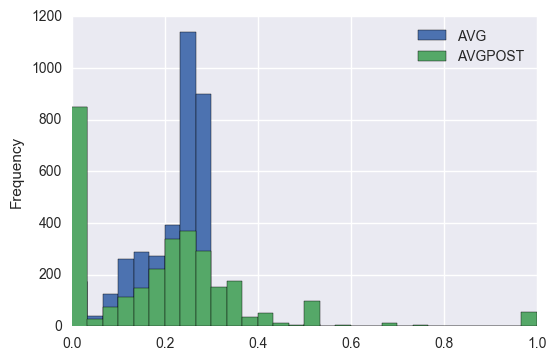

In [49]:
%matplotlib inline

#allow figures to continue opening past warnings
plt.rcParams.update({'figure.max_open_warning': 0})

#finding the means of the two groups 
print 'The average of players batting in the regular season is:', round(batting_combined['AVG'].mean(),3)
print 'The average of players batting in the post season is:', round(batting_combined['AVGPOST'].mean(),3)

#placing the two sets of avg data into one df to be used when plotting and testing
avg_avgpost = batting_combined.loc[:,['AVG', 'AVGPOST']]

#checking out normality of distributions
avg_avgpost.plot.hist(by='AVG', bins=30);


## Determine Statistical Sig of means difference


In [50]:
#running a paired t-test to determine if diff of means could be due to chance
scipy.stats.ttest_rel(avg_avgpost.loc[:, 'AVG'], avg_avgpost.loc[:, 'AVGPOST'], axis=0, nan_policy='omit')


Ttest_relResult(statistic=12.297664268621062, pvalue=5.9131855996600482e-34)

## Investigate variables that could explain difference

In [51]:
#investigate whether salaries have an impact by checking the correlation with AVG_DIFF
batting_combined_salaries = combine_dfs(batting_combined, salaries_df)

#check and see if any player variable correlate to their post season performance
avg_diff_salaries = batting_combined_salaries.loc[:,['AVG_DIFF', 'salary']]
corr_test = avg_diff_salaries.corr()

print 'The correlation between salaries and the incr/dec of batting avg is:', round(corr_test.iloc[1,0],3)

The correlation between salaries and the incr/dec of batting avg is: 0.005


### Check correlation to college attendance

In [37]:
avg_diff_college = batting_combined_college.loc[:,['AVG_DIFF', 'yearID']]
corr_test = avg_diff_college.corr()

#print avg_diff_college

print 'The correlation between playing college ball and the incr/dec of batting avg is:', round(corr_test.iloc[1,0],3)

The correlation between playing college ball and the incr/dec of batting avg is: 0.029


### Check correlation to receiving awards during their career

In [53]:
avg_diff_awards = batting_combined_awards.loc[:,['AVG_DIFF', 'yearID']]
corr_test = avg_diff_awards.corr()

#print avg_diff_college

print 'The correlation between playing college ball and the incr/dec of batting avg is:', round(corr_test.iloc[1,0],3)

The correlation between playing college ball and the incr/dec of batting avg is: 0.038
